# Decision Trees
### One of the many qualities of Decision Trees is that they require very little data preparation. In fact, they don’t require feature scaling or centering at all.

In [1]:
# %load ../helpers/header.py

SUB_DIR = "Trees"

# load ENV path to project from .profile 
import os, sys
PROJECT_ROOT_DIR=os.environ.get('ML_PATH')
sys.path.append(os.path.join(PROJECT_ROOT_DIR, "helpers")) # add helper modules to path

# MPL 
import MPL_header #load common MPL imports (from helpers)
import matplotlib.pyplot as plt
%matplotlib inline 
# %matplotlib widget 

# NP, constant seed, PD 
import numpy as np
np.random.seed(12345)
import pandas as pd

# Where to save the figures
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "fig", SUB_DIR)
# IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "fig")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

### Training and Visualizing a Decision Tree

In [6]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris.data[:, 2:] # petal length and width
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X, y)

DecisionTreeClassifier(max_depth=2, random_state=42)

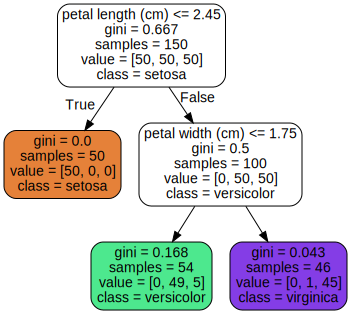

In [7]:
from graphviz import Source
from sklearn.tree import export_graphviz

export_graphviz(
        tree_clf,
        out_file=os.path.join(IMAGES_PATH, "iris_tree.dot"),
        feature_names=iris.feature_names[2:],
        class_names=iris.target_names,
        rounded=True,
        filled=True
    )

Source.from_file(os.path.join(IMAGES_PATH, "iris_tree.dot"))

### Convert to png with `dot -Tpng iris_tree.dot -o iris_tree.png`
A node’s *samples* attribute counts how many training instances it applies to.  
*value* attribute tells you how many training instances of each class this node applies to.  
*gini* attribute measures its impurity: a node is “pure” (gini=0) if all training instances it applies to belong to the same class.

Scikit-Learn uses the CART algorithm, which produces only binary trees: nonleaf nodes always have two children (i.e., questions only have yes/no answers). However, other algorithms such as ID3 can produce Decision Trees with nodes that have more than two children.

### Estimating Class Probabilities

In [8]:
tree_clf.predict_proba([[5, 1.5]])

array([[0.        , 0.90740741, 0.09259259]])

In [9]:
tree_clf.predict([[5, 1.5]])

array([1])

The CART Training Algorithm (Classification and Regression Tree). It searches for the pair (k, tk) (feature, feature_threshold) that produces the purest subsets (weighted by their size). A greedy algorithm often produces a solution that’s reasona‐ bly good but not guaranteed to be optimal; it requires $O(e^m)$ time. A set’s entropy is zero when it contains instances of only one class.


### Regression

In [13]:
# Quadratic training set + noise
np.random.seed(42)
m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(m, 1) / 10

In [14]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

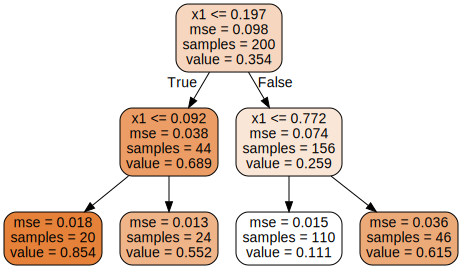

In [19]:
export_graphviz(
        tree_reg,
        out_file=os.path.join(IMAGES_PATH, "tree_reg.dot"),
        feature_names=["x1"],
        rounded=True,
        filled=True
    )

Source.from_file(os.path.join(IMAGES_PATH, "tree_reg.dot"))


4 y regions for max_depth=2, instead of impurity (or entropy) now minimising MSE (weighted by entries)

## Instability
Overfitting for e.g. roations (love orthogonal decision boundaries) --> use PCA

Saving figure sensitivity_to_rotation_plot


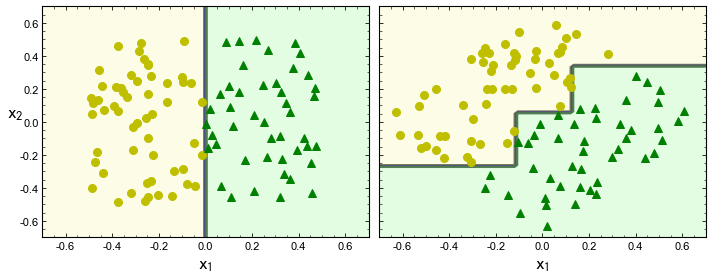

In [22]:
np.random.seed(6)
Xs = np.random.rand(100, 2) - 0.5
ys = (Xs[:, 0] > 0).astype(np.float32) * 2

angle = np.pi / 4
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
Xsr = Xs.dot(rotation_matrix)

tree_clf_s = DecisionTreeClassifier(random_state=42)
tree_clf_s.fit(Xs, ys)
tree_clf_sr = DecisionTreeClassifier(random_state=42)
tree_clf_sr.fit(Xsr, ys)

from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris virginica")
        plt.axis(axes)
    if iris:
        plt.xlabel("Petal length", fontsize=14)
        plt.ylabel("Petal width", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf_s, Xs, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)
plt.sca(axes[1])
plot_decision_boundary(tree_clf_sr, Xsr, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)
plt.ylabel("")

save_fig("sensitivity_to_rotation_plot")
plt.show()